Notes:
- Tried getting it to work with mixed precision to fp16 but it doesn't seem like converters support half data type atm

Sources:
https://stackoverflow.com/questions/58276161/problem-when-converting-pytorch-image-classifier-to-mlmodel-returns-same-softma
- mentions the medium article and fixed it? Couldn't get cuda working

https://medium.com/@hungminhnguyen/convert-fast-ai-trained-image-classification-model-to-ios-app-via-onnx-and-apple-core-ml-5fdb612379f1


In [1]:
from fastai.vision import *

In [2]:
np.random.seed(42)

In [3]:
path = Path('kaggle/working')

In [4]:
data = ImageDataBunch.from_folder('/kaggle/input/sugar-vs-tahoe/', train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [5]:
data.classes

['Sugar', 'Tahoe']

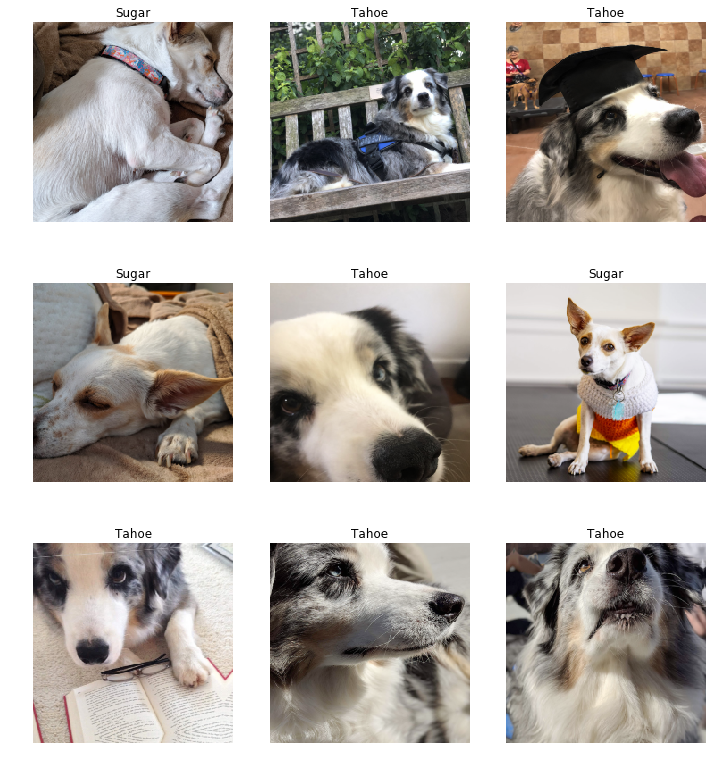

In [6]:
# Sanity check to make sure importing images went through
data.show_batch(rows=3, figsize=(10,11))

In [7]:
for cls in data.classes:
    print(len(cls))

5
5


In [8]:
len(data.train_ds), len(data.valid_ds)

(82, 20)

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, model_dir="/kaggle/model")
# learn = cnn_learner(data, models.resnet50, metrics=error_rate, model_dir="/kaggle/model").to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 85130871.84it/s]


In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.057801,0.741441,0.450000,00:39
1,0.912775,0.147531,0.100000,00:37
2,0.603169,0.113569,0.100000,00:39
3,0.448489,0.080320,0.050000,00:37


In [12]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

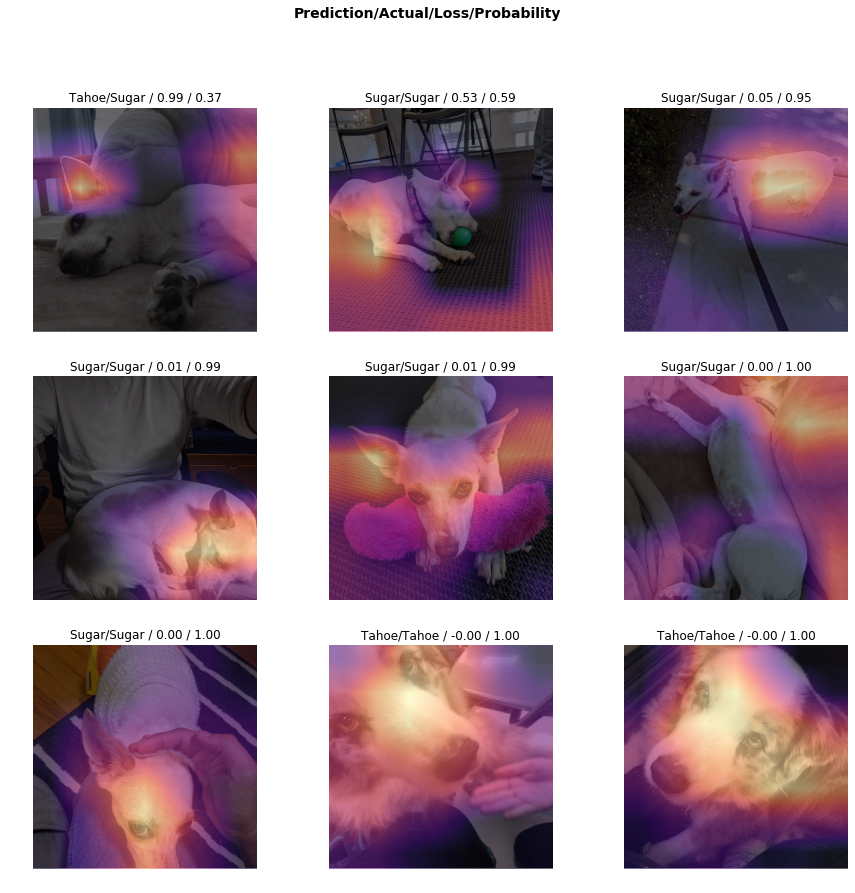

In [13]:
# Note: these are images that are in the top_losses section. Model was not sure what these were 
interp.plot_top_losses(9, figsize=(15,14),  heatmap = True)

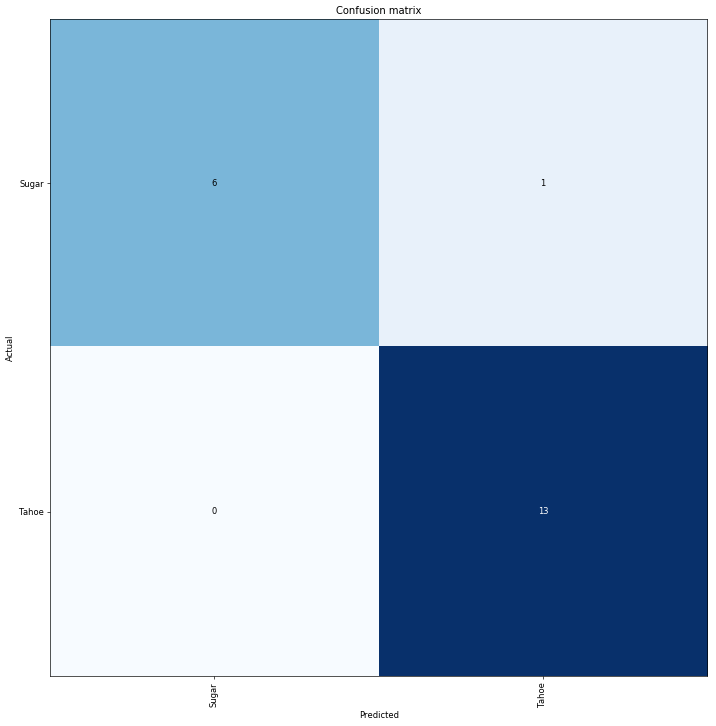

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [15]:
learn.save('/kaggle/working/resnet50_initial_training')

# Convert to ONNX Format
Code from https://github.com/jalola/fastai2coreml/blob/master/lesson1-rxt50.ipynb?source=post_page-----5fdb612379f1----------------------

In [16]:
from fastai.imports import *

arch = 'resnet50'
sz = (1000, 667)
bs=20

In [17]:
# !pip install coremltools
!pip install onnx-coreml

     |████████████████████████████████| 81kB 2.4MB/s eta 0:00:011
     |████████████████████████████████| 7.1MB 7.9MB/s eta 0:00:01
     |████████████████████████████████| 3.4MB 22.7MB/s eta 0:00:01
  Found existing installation: onnx 1.6.0
    Uninstalling onnx-1.6.0:
      Successfully uninstalled onnx-1.6.0


In [18]:
learn.precompute=False
learn.unfreeze()
learn.load('/kaggle/working/resnet50_initial_training')

Learner(data=ImageDataBunch;

Train: LabelList (82 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tahoe,Tahoe,Tahoe,Tahoe,Tahoe
Path: /kaggle/input/sugar-vs-tahoe;

Valid: LabelList (20 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tahoe,Sugar,Sugar,Tahoe,Tahoe
Path: /kaggle/input/sugar-vs-tahoe;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [19]:
import torch
import torch.nn as nn
import numpy as np
from onnx_coreml import convert
from torch.autograd import Variable
import torch.onnx
import torchvision
import onnx
from onnx import onnx_pb

def check_onnx_compatible(model, model_name, sz, input_names, output_names):
    dummy_input = Variable(torch.randn(3, sz[0], sz[1])).cpu()
#     dummy_input = Variable(torch.randn(3, sz[0], sz[1])).half().cuda()

    torch.onnx.export(model, dummy_input, \
                      model_name, input_names = input_names, output_names = output_names, verbose=True)
    
    
    # Check again by onnx
    # Load the ONNX model
    onnx_model = onnx.load(model_name)

    # Check that the IR is well formed
    onnx.checker.check_model(onnx_model)

    # Print a human readable representation of the graph
#     onnx.helper.printable_graph(onnx_model.graph)
    print("Done")
    return onnx_model

In [20]:
class ImageScale(nn.Module):
    def __init__(self): 
        super().__init__()
        self.denominator = torch.full((3, sz[0], sz[1]), 255.0, device=torch.device("cpu"))
#         self.denominator = torch.full((3, sz[0], sz[1]), 255.0, device=torch.device("cuda"), dtype=torch.half)

    def forward(self, x): return torch.div(x, self.denominator).unsqueeze(0)

In [21]:
final_model = [ImageScale()] + [learn.model] + [nn.Softmax(dim=-1)]
final_model = nn.Sequential(*final_model)

In [22]:
final_model.eval()

Sequential(
  (0): ImageScale()
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
      

In [23]:
model_name = "SugarOrTahoe"

# Convert Pytorch model to onnx model & check if it is convertible
onnx_model = check_onnx_compatible(final_model, model_name, sz, input_names=['image'], output_names=['sugarortahoe'])

# Convert onnx model to Apple Core ML
mlmodel = convert(model=model_name, image_input_names = ['image'], mode='classifier', class_labels=['Sugar', 'Tahoe'], target_ios='13')
mlmodel.author = 'RaymondDashWu'
mlmodel.license = 'MIT'
mlmodel.short_description = 'This model takes a picture of a dog at Make School and tries to predict which one it is. V1 Sugar or Tahoe'
mlmodel.input_description['image'] = 'Image of a dog that goes to Make School'
mlmodel.output_description['sugarortahoe'] = 'Confidence and label of predicted dog'
mlmodel.output_description['classLabel'] = 'Label of predicted dog'

mlmodel.save('/kaggle/working/'f'{model_name}.mlmodel')

graph(%image : Float(3, 1000, 667),
      %1.0.0.weight : Float(64, 3, 7, 7),
      %1.0.1.weight : Float(64),
      %1.0.1.bias : Float(64),
      %1.0.1.running_mean : Float(64),
      %1.0.1.running_var : Float(64),
      %1.0.1.num_batches_tracked : Long(),
      %1.0.4.0.conv1.weight : Float(64, 64, 1, 1),
      %1.0.4.0.bn1.weight : Float(64),
      %1.0.4.0.bn1.bias : Float(64),
      %1.0.4.0.bn1.running_mean : Float(64),
      %1.0.4.0.bn1.running_var : Float(64),
      %1.0.4.0.bn1.num_batches_tracked : Long(),
      %1.0.4.0.conv2.weight : Float(64, 64, 3, 3),
      %1.0.4.0.bn2.weight : Float(64),
      %1.0.4.0.bn2.bias : Float(64),
      %1.0.4.0.bn2.running_mean : Float(64),
      %1.0.4.0.bn2.running_var : Float(64),
      %1.0.4.0.bn2.num_batches_tracked : Long(),
      %1.0.4.0.conv3.weight : Float(256, 64, 1, 1),
      %1.0.4.0.bn3.weight : Float(256),
      %1.0.4.0.bn3.bias : Float(256),
      %1.0.4.0.bn3.running_mean : Float(256),
      %1.0.4.0.bn3.running_var :

Done
1/188: Converting Node Type Div
2/188: Converting Node Type Unsqueeze
3/188: Converting Node Type Conv
4/188: Converting Node Type BatchNormalization
5/188: Converting Node Type Relu
6/188: Converting Node Type MaxPool
7/188: Converting Node Type Conv
8/188: Converting Node Type BatchNormalization
9/188: Converting Node Type Relu
10/188: Converting Node Type Conv
11/188: Converting Node Type BatchNormalization
12/188: Converting Node Type Relu
13/188: Converting Node Type Conv
14/188: Converting Node Type BatchNormalization
15/188: Converting Node Type Conv
16/188: Converting Node Type BatchNormalization
17/188: Converting Node Type Add
18/188: Converting Node Type Relu
19/188: Converting Node Type Conv
20/188: Converting Node Type BatchNormalization
21/188: Converting Node Type Relu
22/188: Converting Node Type Conv
23/188: Converting Node Type BatchNormalization
24/188: Converting Node Type Relu
25/188: Converting Node Type Conv
26/188: Converting Node Type BatchNormalization
27

## Sanity checking results

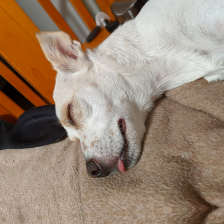

In [24]:
#from 0-81
learn.data.train_ds[81][0]

In [25]:
learn.predict(learn.data.train_ds[81][0])

(Category Sugar, tensor(0), tensor([0.8601, 0.1399]))

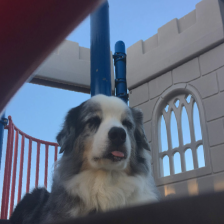

In [26]:
learn.data.train_ds[25][0]

In [27]:
learn.predict(learn.data.train_ds[25][0])

(Category Tahoe, tensor(1), tensor([5.1610e-09, 1.0000e+00]))

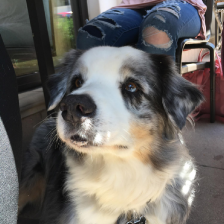

In [28]:
# from 0-19
learn.data.valid_ds[11][0]

In [29]:
learn.predict(learn.data.valid_ds[11][0])

(Category Tahoe, tensor(1), tensor([1.9399e-09, 1.0000e+00]))

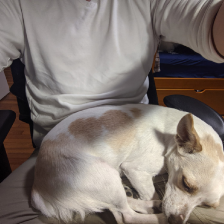

In [30]:
learn.data.valid_ds[1][0]

In [31]:
learn.predict(learn.data.valid_ds[1][0])

(Category Sugar, tensor(0), tensor([0.9862, 0.0138]))